# 第一个实战项目——波士顿房价预测

听说和手写数字识别**LeNet**并称深度学习的Hello, World!？

kaggle项目地址：https://www.kaggle.com/c/house-prices-advanced-regression-techniques/

该项目属于经典回归预测

## 导入所需的包
不导入包你打算怎么用？造轮子嘛？大佬牛逼Orz

In [1]:
%matplotlib inline
import os
import numpy                   as np
import pandas                  as pd
import matplotlib.pyplot       as plt
import torch
from   torch       import nn
from   torch.utils import data as datatool

|代码段|描述|
|-------|----|
|`%matplotlib inline`|这是一个 IPython 魔法命令，用于在 Jupyter Notebook 中直接显示 Matplotlib 绘制的图形。|
|`import os`|用于处理文件和目录|
|`import numpy as np`|导入 NumPy 库，并将其简写为`np`，用于高效的数值计算和数组操作。|
|`import pandas as pd`|导入 Pandas 库，并将其简写为`pd`，用于数据分析和处理，提供 DataFrame 等数据结构。|
|`import matplotlib.pyplot as plt`|导入`Matplotlib`中的pyplot函数并简写为`plt`|
|`import torch`|导入 PyTorch 库，用于构建和训练神经网络模型。|
|`from torch import nn`|从 PyTorch 库中导入`nn`模块，其中包含神经网络相关的类和函数。|
|`from torch.utils import data as datatool`|从 PyTorch 库中的`utils`模块中导入`data`模块，其中包含数据处理相关的类和函数。|

## 数据处理

### 数据读取
获取自身文件夹的路径，分别得到训练集与验证集中的路径后，由pandas中的read_csv进行读取

In [2]:
current_dir = os.getcwd()
train_path  = os.path.join(current_dir, "train.csv")
train_raw   = pd.read_csv(train_path)
test_path   = os.path.join(current_dir, "test.csv")
test_raw    = pd.read_csv(test_path)

|代码段|描述|
|-------|----|
|`os.getcwd()`|获取当前文件夹|
|`os.path.join(A, B)`|将文件夹路径A与csv文件名B链接得到csv文件访问路径|
|`pd.read_csv`|使用pandas对csv文件进行读取|

### 数据查看

你也不希望你的数据有问题吧

In [3]:
print(train_raw.shape)
print(test_raw.shape)
print(train_raw.iloc[0:5, [0, 1, 2, 3, -3, -2, -1]])

(1460, 81)
(1459, 80)
   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000
4   5          60       RL         84.0       WD        Normal     250000


|代码段|描述|
|-------|----|
|`"数据".shape`|获取当前数据形状|
|`"数据".iloc`|基于整数位置进行数据选择的索引方法|

### 数据整合
将训练集（train_raw）与验证集(test_raw)进行整合，同步数据处理

In [4]:
all_feats_raw = pd.concat((train_raw.iloc[:, 1:-1], test_raw.iloc[:, 1:]))
print(all_feats_raw.iloc[0:5, [0, 1, 2, 3, -3, -2, -1]])

   MSSubClass MSZoning  LotFrontage  LotArea  YrSold SaleType SaleCondition
0          60       RL         65.0     8450    2008       WD        Normal
1          20       RL         80.0     9600    2007       WD        Normal
2          60       RL         68.0    11250    2008       WD        Normal
3          70       RL         60.0     9550    2006       WD       Abnorml
4          60       RL         84.0    14260    2008       WD        Normal


|代码段|描述|
|----|----|
|`pd.concat`|链接两个数据|

### 数据预处理
对数据预处理使得更好地投喂给你的神经网络

#### 量化值处理
对量化值进行归一化，你可以理解成将蔬菜切成等份的小块以便食用

In [5]:
numeric_feats = all_feats_raw.dtypes[all_feats_raw.dtypes != 'object'].index

all_feats_raw[numeric_feats] = all_feats_raw[numeric_feats].apply(
    lambda x: (x - x.mean()) / (x.std()))
all_feats_raw[numeric_feats] = all_feats_raw[numeric_feats].fillna(0)

print(all_feats_raw.iloc[0:10, [0, 1, 2, 3, -3, -2, -1]])

   MSSubClass MSZoning  LotFrontage   LotArea    YrSold SaleType SaleCondition
0    0.067320       RL    -0.184443 -0.217841  0.157619       WD        Normal
1   -0.873466       RL     0.458096 -0.072032 -0.602858       WD        Normal
2    0.067320       RL    -0.055935  0.137173  0.157619       WD        Normal
3    0.302516       RL    -0.398622 -0.078371 -1.363335       WD       Abnorml
4    0.067320       RL     0.629439  0.518814  0.157619       WD        Normal
5   -0.167877       RL     0.672275  0.500430  0.918095       WD        Normal
6   -0.873466       RL     0.243916 -0.010665 -0.602858       WD        Normal
7    0.067320       RL     0.000000  0.027119  0.918095       WD        Normal
8   -0.167877       RM    -0.784145 -0.513264  0.157619       WD       Abnorml
9    3.124875       RL    -0.826981 -0.348436  0.157619       WD        Normal


|代码段|描述|
|----|----|
|`"数据".dtype`|获取数据的类型|
|`"数据".index`|获取列表中数据的索引值|
|`"数据".mean`|获取该列的平均值|
|`"数据".std`|获取该列中的标准差|
|`"数据".apply`|将数据进行替换|
|`"数据".fillna`|对列表中值为Nan的数进行填充|

#### 非量化值处理
不同酱汁对食材口味的影响？？？

对无法量化的值，使用独热编码进行处理以表示有无

In [6]:
all_feats_raw = pd.get_dummies(all_feats_raw, dummy_na=True).astype('float32')
all_feats_raw.shape

(2919, 330)

|代码段|描述|
|----|----|
|`dummy_na`|是否对Nan值进行处理？|
|`pd.get_dummies`|调用pandas中的get_dummies以进行独热编码处理|
|`"数据".astype('类型')`|对数据的类型进行变化|

### 数据分离
现在需要使训练集与验证集分离，分别进行不同的操作

In [7]:
n_train      = train_raw.shape[0]
train_feats  = torch.tensor(
               all_feats_raw[:n_train].values, dtype=torch.float32)
test_feats   = torch.tensor(
               all_feats_raw[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(
               train_raw.SalePrice.values.reshape(-1, 1), dtype=torch.float32)

|代码段|描述|
|----|----|
|`"数据".values`|获取数据中的内容|
|`dtype=torch.类型`|决定输出数据的类型|
|`torch.tensor`|将数据变为torch张量以进行深度学习处理|
|`"数据".reshape`|对张量进行尺寸变化|

## 训练准备

### 模型选择
入门起见，选择简单的一层模型，即线性模型。

In [8]:
in_feats = train_feats.shape[1]

def get_net():
    net = nn.Sequential(nn.Linear(in_feats, 1), nn.ReLU())
    return net

|代码段|描述|
|----|----|
|`nn.MSELoss`|$\frac{\sum_{i=1}^{n} (x_{pred\_i} - x_{true\_i})^2} {n}$ 简单易用|
|`nn.Linear(输入数, 输出数)`|使用线性模型|
|`nn.Sequential`|创建一个序列，以自定义序列中模型的选择|

### 评价函数
选择合理的评价函数，选择相对误差或对数误差

In [9]:
loss     = nn.MSELoss()

def log_rmse(net, feats, labels):
    clipped_preds = torch.clamp(net(feats), 1, float('inf'))
    rmse_loss     = torch.sqrt(
                    loss(torch.log(clipped_preds), torch.log(labels)))
    return rmse_loss.item()

|代码段|描述|
|----|----|
|`torch.clamp("数据", x, y)`|将数据限制在\[x, y]内|
|`torch.log("数据")`|对数据做对数处理|
|`torch.sqrt("数据")`|对数据做开方处理|
|`"数据".item()`|以python数字返回数据|

### 训练函数
数（zen）据（me）喂（chi）食（fan）

In [10]:
def train(net, train_feats, train_labels, test_feats, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    # 数据热身(bushi
    train_ls, test_ls = [], []
    dataset           = datatool.TensorDataset(train_feats, train_labels)
    train_iter        = datatool.DataLoader(
                        dataset, batch_size=batch_size, shuffle=True)
    optimizer         = torch.optim.Adam(net.parameters(), 
                                         lr=learning_rate, 
                                         weight_decay=weight_decay)
    # 开始训练，训练epoch次
    for epoch in range(num_epochs):
        # 每epoch中，循环将batch_size个数据输入训练
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_feats, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_feats, test_labels))
    return train_ls, test_ls

|代码段|描述|
|----|----|
|`TensorDataset`|链接训练特征与训练标签|
|`DataLoader`|创建一个数据加载器，指定每次训练批次数量与是否打乱|
|`net.parameters()`|将网络中的可学习参数喂给Adam优化器|
|`torch.optim.Adam`|使用Adam优化器作为网络的更新器|
|`optimizer.zero_grad()`|每次加载新批次时清空上一个批次的梯度信息|
|`"损失".backward()`|对损失求梯度信息|
|`optimizer.step()`|使用优化器更新更新网络中的参数信息|
|`"列表".append`|每次训练循环后加入此次的评价损失|

### K折交叉验证
将模型正式验证前，先不断训练至自己满意的状态，然而大多数情况下，训练集不一定够用，需要合理的评价方法

#### 构造K-1部分的训练集数据与1个尺度的验证集

In [11]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

|代码段|描述|
|----|----|
|`assert`|python中的断言，如果情况错误将直接报错|
|`slice(x, y)`|默认步长为一，返回x至y-1内的所有索引值|
|`torch.cat([x, y], z)`|torch的数据链接方式，将x与y沿z轴方向进行链接|

#### 构造具体的K次训练循环

In [12]:
def k_fold(k, X_train, y_train, 
           num_epochs, learning_rate, weight_decay,batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, 
                                   learning_rate, weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            plt.figure(dpi=300, figsize=(5,3))
            plt.xlabel('epoch')
            plt.ylabel('rmse')
            plt.yscale('log')
            plt.grid(True)
            plt.plot(list(range(1, num_epochs + 1)), train_ls,
                     label='train', color='blue', linestyle='-')
            plt.plot(list(range(1, num_epochs + 1)), valid_ls,
                     label='valid', color='red', linestyle='--')
            plt.legend()
        print(f'折{i + 1}, 训练log rmse:{float(train_ls[-1]):f},'
              f'验证log rmse:{float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

|代码段|描述|
|----|----|
|`plt.figure(dpi=z, figsize=(x, y))`|绘制DPI为z，大小为(x, y)的图表|
|`plt.xlabel('x轴名称')`|图表x轴名称设置|
|`plt.ylabel('y轴名称')`|图表y轴名称设置|
|`plt.yscale('log')`|图标y轴以对数缩放|
|`plt.grid(True)`|绘制图表背景网格|
|`plt.plot(x, y, label='线条名称', color='颜色', linestyle='线条样式')`|绘制线条及设置线条名称、颜色、线条样式等|
|`plt.legend()`|用于表示图表中线条的说明|

## 训练

### K折训练

折1, 训练log rmse:0.136072,验证log rmse:0.143191
折2, 训练log rmse:0.133534,验证log rmse:0.148660
折3, 训练log rmse:0.131861,验证log rmse:0.141967
折4, 训练log rmse:0.136848,验证log rmse:0.140732
折5, 训练log rmse:0.131191,验证log rmse:0.171230
5-折验证: 平均训练log rmse: 0.133901, 平均验证log rmse: 0.149156


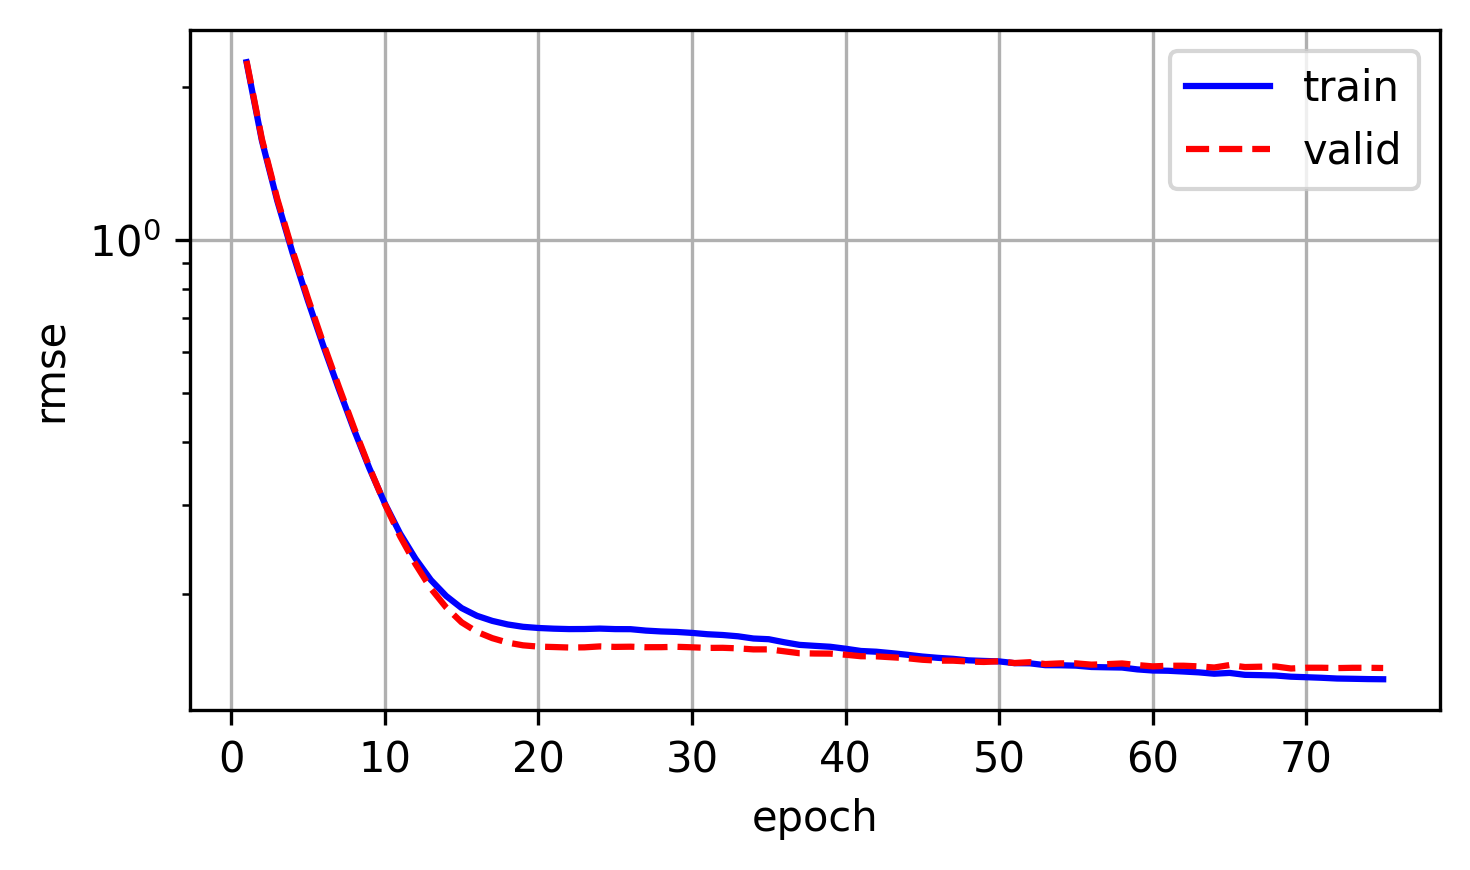

In [13]:
k, num_epochs, lr, weight_decay, batch_size = 5, 75, 22.5, 0, 64
train_l, valid_l = k_fold(k, train_feats, train_labels,
                          num_epochs, lr, weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

### 使用全部数据进行预测且生成csv文件

In [16]:
def train_and_pred(train_feats, test_feats, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net         = get_net()
    train_ls, _ = train(net, train_feats, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    
    plt.figure(figsize=(5, 3), dpi=300)
    plt.xlabel('epoch')
    plt.ylabel('log rmse')
    plt.yscale('log')
    plt.plot(np.arange(1, num_epochs + 1), train_ls)
    print(f'训练log rmse：{float(train_ls[-1]):f}')
    
    preds = net(test_feats).detach().numpy()
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

|代码段|描述|
|----|----|
|`pd.Series`|创建pd一维数组|
|`"数据".to_csv`|将数据保存为csv文件|

训练log rmse：0.131455


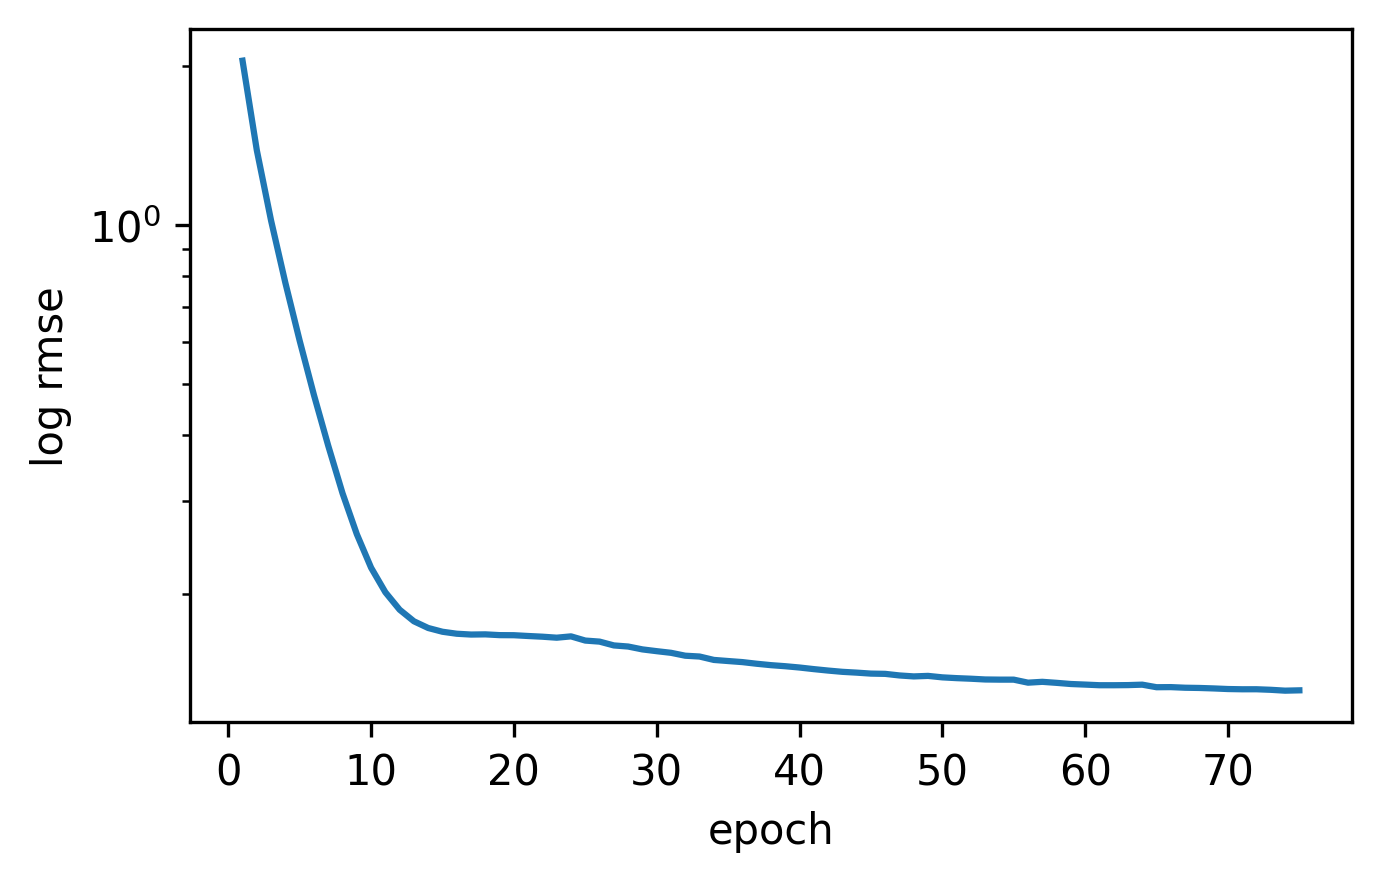

In [17]:
train_and_pred(train_feats, test_feats, train_labels, test_raw,
               num_epochs, lr, weight_decay, batch_size)